# LSTM for sequence classification (Quora)

In this notebook we try our best to solve a Kaggle competition problem in which we are trying to answer the following question:
Can you identify question pairs that have the same intent?

https://www.kaggle.com/c/quora-question-pairs

In [1]:
%matplotlib inline
import lstm_utils
import importlib
importlib.reload(lstm_utils)
from lstm_utils import *
import sgdr
importlib.reload(sgdr)
from sgdr import *
import codecs

Using TensorFlow backend.


## Cleaning the Quora pairs dataset

To get the data you should use this kaggle api: https://github.com/floydwch/kaggle-cli.
(You have to first accept the rules for this competition.)

In [2]:
path = "/data/yinterian/quora-question-pairs/"

In [3]:
train = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")

In [4]:
test[pd.isnull(test).any(axis=1)]

,test_id,question1,question2
379205,379205,How I can learn android app development?,NaN
817520,817520,How real can learn android app development?,NaN
943911,943911,How app development?,NaN
1046690,1046690,NaN,How I what can learn android app development?
1270024,1270024,How I can learn app development?,NaN
1461432,1461432,NaN,How distinct can learn android app development?


In [5]:
train = train.fillna(" ")
test = test.fillna(" ")

In [6]:
# The function "text_to_wordlist" is from
# https://www.kaggle.com/currie32/quora-question-pairs/the-importance-of-cleaning-text
def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

In [23]:
def read_data(filename, train=True):
    texts_1 = [] 
    texts_2 = []
    labels = []
    col1, col2, col3 = 3, 4, 5
    if not train:
       col1, col2, col3 = 1, 2, 0 
    with codecs.open(filename, encoding='utf-8') as f:
        reader = csv.reader(f, delimiter=',')
        header = next(reader)
        for values in reader:
            texts_1.append(text_to_wordlist(values[col1]))
            texts_2.append(text_to_wordlist(values[col2]))
            labels.append(int(values[col3]))
    print('Found %s texts in train.csv' % len(texts_1))
    # for test set the last column is the id.
    return texts_1, texts_2, labels

In [15]:
train_1, train_2, labels = read_data(path + "train.csv", train=True)

Found 404290 texts in train.csv


In [24]:
test_1, test_2, ids = read_data(path + "test.csv", train=False)

Found 2345796 texts in train.csv


In [21]:
print(train_1[0],train_2[0], labels[0])

what is the step by step guide to invest in share market in india  what is the step by step guide to invest in share market  0


In [22]:
print(test_1[0],test_2[0])

how does the surface pro himself 4 compare with ipad pro  why did microsoft choose core m3 and not core i3 home surface pro 4 


In [29]:
f = open(path + 'train_clean.csv', 'w')
for i in range(len(train_1)):
    f.write(f'{train_1[i]},{train_2[i]},{labels[i]}\n')
f.close()

In [31]:
f = open(path + 'test_clean.csv', 'w')
for i in range(len(test_1)):
    f.write(f'{ids[i]},{test_1[i]},{test_2[i]}\n')
f.close()

## Tokenizing

In [7]:
train = pd.read_csv(path + "train_clean.csv", names=["seq1", "seq2", "label"])
test = pd.read_csv(path + "test_clean.csv", names=["id", "seq1", "seq2"])
print(train.shape, test.shape)

(404290, 3) (2345796, 3)


In [8]:
train = train.fillna(" ")
test = test.fillna(" ")

In [9]:
train[pd.isnull(train).any(axis=1)]

,seq1,seq2,label


In [10]:
train = train.dropna(axis=0, how='any')
train[pd.isnull(train).any(axis=1)]

,seq1,seq2,label


In [11]:
test[pd.isnull(test).any(axis=1)]

,id,seq1,seq2


In [12]:
 seqs = np.concatenate([train["seq1"].values, train["seq2"].values, test["seq1"].values, test["seq2"].values])

In [13]:
seqs.shape

(5500172,)

In [14]:
MAX_NB_WORDS = 50000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(list(seqs))

In [15]:
seq1 = tokenizer.texts_to_sequences(train["seq1"])
seq2 = tokenizer.texts_to_sequences(train["seq2"])
test_seq1 = tokenizer.texts_to_sequences(test["seq1"])
test_seq2 = tokenizer.texts_to_sequences(test["seq2"])

word_index = tokenizer.word_index

In [16]:
seq1[0:5]

[[2, 3, 1, 1254, 61, 1254, 2921, 8, 578, 7, 759, 370, 7, 35],
 [2, 3, 1, 532, 10, 16563, 11914, 4, 22978, 4743],
 [5, 13, 4, 293, 1, 423, 10, 18, 334, 1724, 153, 127, 6, 2885],
 [15, 47, 4, 3396, 278, 3289, 5, 13, 4, 682, 17],
 [23, 48, 5750, 7, 204, 1593, 2208, 10718, 12, 1892, 7839, 5204]]

In [17]:
l = [len(s) for s in seq1]

In [18]:
ll = pd.Series(l)
ll.quantile([0.1, 0.5, 0.95])

0.10     6.0
0.50    10.0
0.95    22.0
dtype: float64

In [19]:
word_index
print('Found %s unique tokens' % len(word_index))

Found 120499 unique tokens


In [20]:
MAX_SEQUENCE_LENGTH = 20
print('Found %s unique tokens' % len(word_index))
data_1 = sequence.pad_sequences(seq1, maxlen=MAX_SEQUENCE_LENGTH)
data_2 = sequence.pad_sequences(seq2, maxlen=MAX_SEQUENCE_LENGTH)
labels = np.array(train["label"])
print('Shape of data tensor:', data_1.shape)
print('Shape of label tensor:', labels.shape)

Found 120499 unique tokens
Shape of data tensor: (404290, 20)
Shape of label tensor: (404290,)


In [21]:
word_index
idx2word = {v: k for k, v in word_index.items()}

In [22]:
idx2word[1]

'the'

In [24]:
VALIDATION_SPLIT = 0.2
perm = np.random.permutation(len(data_1))
n = int(np.ceil(len(data_1)*(1-VALIDATION_SPLIT)))
n

323432

In [25]:
# split train and validation
perm = np.random.permutation(len(data_1))
n = int(np.ceil(len(data_1)*(1-VALIDATION_SPLIT)))
idx_train = perm[:n]
idx_val = perm[n:]

x1_train = data_1[idx_train]
x2_train = data_2[idx_train]
y_train = labels[idx_train]

x1_val = data_1[idx_val]
x2_val = data_2[idx_val]
y_val = labels[idx_val]

re_weight = True
weight_val = np.ones(len(y_val))
if re_weight:
    weight_val *= 0.472001959
    weight_val[y_val==0] = 1.309028344

# Defining the model

In [26]:
MAX_SEQUENCE_LENGTH = 20
MAX_NB_WORDS = 50000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2

In [27]:
glove_path = "/data/yinterian/Glove/6B.50d"
emb = create_emb(MAX_NB_WORDS, glove_path, idx2word)
emb.shape

(50000, 50)

In [28]:
# fix random seed for reproducibility
np.random.seed(3)

In [29]:
from keras.layers.merge import concatenate
#class_weight = {0: 1.309028344, 1: 0.472001959}

def get_model():
    nb_words = MAX_NB_WORDS
    embedding_layer = Embedding(nb_words,
        EMBEDDING_DIM,
        weights=[emb],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=True)
    lstm_layer = LSTM(100, dropout=0.2, recurrent_dropout=0.2)

    input1 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    emb_seq1 = embedding_layer(input1)
    x1 = lstm_layer(emb_seq1)

    input2 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    emb_seq2 = embedding_layer(input2)
    x2 = lstm_layer(emb_seq2)

    x = concatenate([x1, x2])
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = Dense(30, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    preds = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input1, input2], outputs=preds)
    model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
    return model

In [35]:
#class_weight=class_weight,
model = get_model()
batch_size=2048
steps_per_epoch = math.ceil(323432/batch_size)
cb = LR_Finder(steps_per_epoch, start_lr=1e-7, end_lr=3)
model.fit([x1_train, x2_train], y_train, \
          validation_data=([x1_val, x2_val], y_val, weight_val), \
          epochs=1, batch_size=batch_size, shuffle=True, \
          callbacks=[cb], verbose=1)

Train on 323432 samples, validate on 80858 samples
Epoch 1/1
323432/323432 [==============================] - 16s - loss: 1.2569 - acc: 0.5704 - val_loss: 2.9032 - val_acc: 0.6271


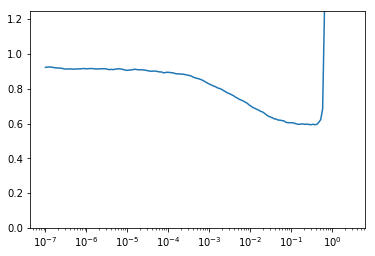

In [36]:
%matplotlib inline
plt.plot(cb.history['lr'], cb.losses)
plt.ylim((0,1.25))
plt.xscale('log');

In [37]:
#early_stopping =EarlyStopping(monitor='val_loss', patience=3)
#bst_model_path = STAMP + '.h5'
#model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)
# callbacks=[early_stopping, model_checkpoint]
# validation_data=([x1_val, x2_val], y_val, weight_val), \

hist = model.fit([x1_train, x2_train], y_train, \
        validation_data=([x1_val, x2_val], y_val), \
        epochs=10, batch_size=2048, shuffle=True)

#model.load_weights(bst_model_path)
#bst_val_score = min(hist.history['val_loss'])
model.optimizer.lr.assign(0.01)

Train on 323432 samples, validate on 80858 samples
Epoch 1/10
323432/323432 [==============================] - 15s - loss: 5.9484 - acc: 0.6309 - val_loss: 5.9794 - val_acc: 0.6290
Epoch 2/10
323432/323432 [==============================] - 15s - loss: 5.9556 - acc: 0.6304 - val_loss: 5.9794 - val_acc: 0.6290
Epoch 3/10
323432/323432 [==============================] - 15s - loss: 5.9436 - acc: 0.6312 - val_loss: 5.9794 - val_acc: 0.6290
Epoch 4/10
323432/323432 [==============================] - 16s - loss: 5.9436 - acc: 0.6312 - val_loss: 5.9794 - val_acc: 0.6290
Epoch 5/10
323432/323432 [==============================] - 16s - loss: 5.9436 - acc: 0.6312 - val_loss: 5.9794 - val_acc: 0.6290
Epoch 6/10
323432/323432 [==============================] - 16s - loss: 5.9436 - acc: 0.6312 - val_loss: 5.9794 - val_acc: 0.6290
Epoch 7/10
323432/323432 [==============================] - 16s - loss: 5.9436 - acc: 0.6312 - val_loss: 5.9794 - val_acc: 0.6290
Epoch 8/10
323432/323432 [=============

<tf.Tensor 'Assign_114:0' shape=() dtype=float32_ref>

## Learning Rate Finder

In [80]:
batch_size=64
steps_per_epoch = math.ceil(25000/batch_size)
cb = LR_Finder(steps_per_epoch, start_lr=1e-7, end_lr=10)
model2.fit(trn, y_train, epochs=1, validation_data=(test, y_test), batch_size=batch_size, 
           callbacks=[cb], verbose=1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 285s - loss: 18.6379 - acc: 0.5463 - val_loss: 235.2400 - val_acc: 0.4986


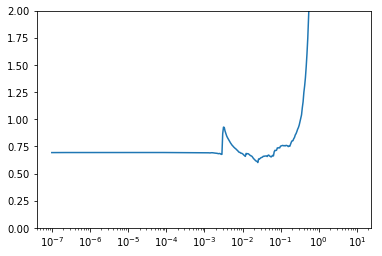

In [84]:
%matplotlib inline
plt.plot(cb.history['lr'], cb.losses)
plt.ylim((0,2))
plt.xscale('log');

## Cosine Annealing

In [38]:
N = 323432
batch_size=2048
steps_per_epoch = math.ceil(N/batch_size)
def fc_cos(model, steps_per_epoch, nc,  cl, lr, tmult=1):
    for i in range(nc):
        cb = CosAnneal(steps_per_epoch, init_lr=lr)
        model.fit([x1_train, x2_train], y_train, \
            validation_data=([x1_val, x2_val], y_val), \
            epochs=10, batch_size=2048, shuffle=True, \
            callbacks=[cb])
        cl *= tmult

In [39]:
model = get_model()
# LSTM is a different beast, It keeps overfitting after lr restarts. 
fc_cos(model, steps_per_epoch, nc=3, cl=10, lr=0.1)

Train on 323432 samples, validate on 80858 samples
Epoch 1/10
323432/323432 [==============================] - 16s - loss: 0.5317 - acc: 0.7383 - val_loss: 0.4968 - val_acc: 0.7600
Epoch 2/10
323432/323432 [==============================] - 15s - loss: 0.4906 - acc: 0.7668 - val_loss: 0.4777 - val_acc: 0.7712
Epoch 3/10
323432/323432 [==============================] - 15s - loss: 0.4685 - acc: 0.7784 - val_loss: 0.4884 - val_acc: 0.7657
Epoch 4/10
323432/323432 [==============================] - 15s - loss: 0.4652 - acc: 0.7798 - val_loss: 0.4916 - val_acc: 0.7648
Epoch 5/10
323432/323432 [==============================] - 15s - loss: 0.4773 - acc: 0.7728 - val_loss: 0.5057 - val_acc: 0.7576
Epoch 6/10
323432/323432 [==============================] - 15s - loss: 0.4869 - acc: 0.7648 - val_loss: 0.5161 - val_acc: 0.7547
Epoch 7/10
323432/323432 [==============================] - 15s - loss: 0.4916 - acc: 0.7618 - val_loss: 0.5151 - val_acc: 0.7509
Epoch 8/10
323432/323432 [=============

## Random parameter search

## References

* https://www.kaggle.com/lystdo/lstm-with-word2vec-embeddings